The general outline of the file is following: Worker functions are declared first, data downloaded and processed.
Then there are calculating functions (followed by graph-drawing), which take a lot of time to finish, so the results are pasted as lists after the graphs. The file may thereforore not be executable with one click - the execution would take hours.

For quickly inspecting the results, skip the computing cells, run the cells containing results and then graphs or other analysing cells.

## Importing libraries ##

In [ ]:
import os
import ast
import re
import json
import itertools
import requests
import wget
from operator import itemgetter
import numpy as np
import pandas as pd
from tempfile import mkdtemp
from shutil import rmtree
from timeit import default_timer as timer
from sys import getsizeof
from bs4 import BeautifulSoup
from nltk.util import ngrams
from nltk.probability import FreqDist
from nltk.tokenize import regexp_tokenize
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, log_loss, recall_score, balanced_accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.base import BaseEstimator, TransformerMixin
from imblearn.pipeline import make_pipeline
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
import matplotlib.pyplot as plt

## Loading and preprocessing data ##
Before continuing, you need to paste the address of the website containing the collected data to the 'site' variable.

In [13]:
"""
Global random seed
"""
np.random.seed(31415)

"""
Load Data from the Server
"""
site = "" # this needs to be entered, link to the website containing collected data
r  = requests.get(site)
data = r.text
soup = BeautifulSoup(data)
file_list = []
for link in soup.find_all('a'):
    loc = link.get('href') 
    if loc == "/":
        continue
    url = site + loc 
    html = requests.get(url).text
    file_list.append(html)
duplicates_indexes = [2,3,5,6,54,60] # these were reported as duplicates
for index in sorted(duplicates_indexes, reverse=True): # remove duplicates
    del file_list[index]
file_list = [ast.literal_eval(x) for x in file_list if x != '[]'] # remove empty history files
file_list = [list(x.values()) for x in file_list] # unpack dictionaires
flj = []
# flatten nested lists
for user in file_list:
    flattened = "" 
    if len(user) > 1:
        for j in user:
            flattened += j
    else:
        flattened = user[0]
    flattened = flattened.splitlines()
    if len(flattened) > 499: # only use files over 500 lines 
        flj.append(flattened)

flj_short = []
for file in flj:
    flj_short.append(file[:]) # used to cut off longer files for faster performance during the development

def build_num_file(lst, str_len = 10):
    """
    Takes in a list of list of lines and replaces all words longer than str_len by their frequency in each user file.
    Returns same list, just with strings replaced.
    """ 
    num_file = []
    for index, file in enumerate(lst):
            section_joined = "\n".join(file)
            tokens = regexp_tokenize(section_joined, pattern=r"\S{1,}")
            top_words = FreqDist(tokens).most_common()
            hashed = [j[0] for j in top_words if (len(j[0]) > str_len)] # if str_len == 1, all strings get hashed
            frequencies_dict = {}
            for frequency, hashed_string in enumerate(hashed):
                frequencies_dict[hashed_string] = str(frequency) 

            file = " ¬ ".join(file) # adding an unusual character to later remove to preserve newlines
            for k in sorted(frequencies_dict.keys(), key=len, reverse=True):
                file = file.replace(k, frequencies_dict[k])
            res = file.split(" ¬ ")
            num_file.append(res)
    return num_file

# creating files where commands are replaced with numbers
num_file = build_num_file(flj_short)
all_num_file = build_num_file(flj_short, str_len=1)

"""
Train test split
For calculating metrics of adjacent lines belonging to the same user, each line needs to carry information about its class.
Raw, numbers and all_numbers lines are joint into one tuple and then split.
"""
X_train, X_test, y_train, y_test = [], [], [], []
for index in range(len(flj_short)):
    joint_files = []
    for line_index in range(len(flj_short[index])):
        if len(flj_short[index][line_index]) != 0:
            reg = flj_short[index][line_index]
            num = num_file[index][line_index]
            all_num = all_num_file[index][line_index]
            joint_files.append((reg, num, all_num, index))
    y = [index for i in range(len(joint_files))]
    mX_train, mX_test, my_train, my_test = train_test_split(joint_files, y, shuffle=False,
                                                    test_size=0.20)
    X_train.extend(mX_train)
    X_test.extend(mX_test)
    y_train.extend(my_train)
    y_test.extend(my_test)

## Definining feature extraction functions ##

In [14]:
# commands and operators that were preserved in the hashing script
commands = ["alias", "apt-get", "aptitude", "aspell", "awk", "base32", "base64", "basename", "bc", "bg", "bind", "break", "builtin", "bzip", "cal", "case", "cat", "cd", "cfdisk", "chattr", "chgrp", "chkconfig", "chmod", "chown", "chpasswd", "chroot", "cksum", "clear", "cmp", "comm", "command", "continue", "cp", "cpio", "cron", "crontab", "csplit", "curl", "cut", "date", "dc", "dd", "ddrescue", "declare", "df", "diff", "diff3", "dig", "dir", "dircolors", "dirname", "dirs", "dmesg", "du", "echo", "egrep", "eject", "emacs", "enable", "env", "eval", "exec", "exit", "expand", "export", "expr", "false", "fdformat", "fdisk", "fg", "fgrep", "file", "find", "fmt", "fold", "for", "free", "fsck", "ftp", "FTP", "fuser", "gawk", "getopts", "git", "grep", "groupadd", "groupdel", "groupmod", "groups", "gzip", "hash", "head", "help", "history", "hostname", "htop", "iconv", "id", "if", "ifconfig", "ifdown", "ifup", "import", "info", "install", "iostat", "ip", "jobs", "join", "kill", "killall", "last", "less", "let", "link", "ln", "local", "locate", "logname", "logout", "look", "lpc", "lpr", "lprm", "ls", "lsattr", "lsblk", "lsof", "lspci", "man", "mkdir", "mkfifo", "mkfile", "mknod", "mktemp", "mmv", "more", "most", "mount", "mtools", "mtr", "mv", "nano", "nc", "netcat", "netstat", "nft", "nice", "nl", "nohup", "notify-send", "nslookup", "op", "open", "passwd", "paste", "perf", "pgrep", "ping", "pkill", "popd", "pr", "printenv", "printf", "ps", "pushd", "pv", "pwd", "python", "quota", "quotacheck", "ram", "rar", "rcp", "read", "readonly", "rename", "return", "rev", "rm", "rmdir", "rpm", "scp", "screen", "sdiff", "sed", "select", "seq", "service", "set", "shift", "shopt", "shutdown", "sleep", "slocate", "sort", "split", "ss", "ssh", "stat", "strace", "su", "sudo", "sum", "suspend", "sync", "tail", "tar", "tee", "test", "time", "timeout", "times", "top", "touch", "tput", "tr", "traceroute", "trap", "tree", "true", "tsort", "tty", "type", "ulimit", "umask", "umount", "uname", "unexpand", "uniq", "units", "unrar", "unset", "unshar", "until", "uptime", "useradd", "userdel", "usermod", "users", "uudecode", "uuencode", "vi", "vim", "vmstat", "w", "wait", "watch", "wc", "whatis", "whereis", "which", "while", "who", "whoami", "write", "xargs", "xdg-open", "xz", "yes", "yum", "zip"] 
operators = [ "", "<", "<<", "<<-", "<>", "<&", ">", ">>", ">|", ">&", "|", "||", ";", ";;", "!", "/", "..", "../", "../../", "(", ")", "&", "&&"]
operators.extend(("\\/", "..\\/", "..\\/..\\/"))

In [15]:
"""
Extract Metrics Features
"""
short_flag_re = re.compile(r"\B-\w{1,4}\b")
hashed_string_re = re.compile(r"\b[-A-Za-z0-9+=\\\/]{42,44}={0,2}")
multi_space_re = re.compile(r" {2,4}")
def extract_segment_metrics(segment, rng):
    """ Calculates various metrics for a list of lines, returns a Series of their values."""
    if rng == 1: # compute only for current line
        leng = 1
    elif rng > 1:
        segment = " ".join(segment)
        leng = rng*2
    hashed_counts = len(re.findall(hashed_string_re, segment))
    multi_space_counts = len(re.findall(multi_space_re, segment))
    flags_counts = len(re.findall(short_flag_re, segment))
    
    commands_vectorizer = CountVectorizer(token_pattern=r"\S{1,}", vocabulary=commands)
    commands_counts = commands_vectorizer.fit_transform([segment])
    commands_counts = int(commands_counts.sum(axis=1))
    operators_vectorizer = CountVectorizer(token_pattern=r"\S{1,}", vocabulary=operators)
    operators_counts = operators_vectorizer.fit_transform([segment])
    operators_counts = int(operators_counts.sum(axis=1))

    splt = segment.split()
    words_count = len(splt)
    lexical_diversity = len(set(splt))/(words_count)

    labels = ["words/line", "commands/line", "operators/line", "hashed/line", "multispace/line", "flags/line", "lexical diversity"]
    labels = [str(rng) + " " + label for label in labels]
    segment_counts = [words_count/leng, commands_counts/leng, operators_counts/leng, hashed_counts/leng, multi_space_counts/leng, flags_counts/leng, lexical_diversity]
    segment_series = pd.Series(segment_counts, index = labels, dtype=np.float16)
    return segment_series 

In [16]:
class FeaturesExtractor(BaseEstimator, TransformerMixin):
    """
    Handles extraction of features.
    toext: a tuple of features to be extracted (ngrams, Fgrams, Numgrams, Agrams, metrics)
    rang = number of adjacent lines to be extracted each way. Block size is 2*rang
    Returns a df that can be fed into classifiers.
    """

    def __init__(self, toext = ((1,), (1,), (2,), (2,), 1), rang = 40):
        self.toext = toext
        self.rang = rang

    def extract_features(self, X, toext, rang):
        file = [i[0] for i in X]
        num_file = [i[1] for i in X]
        all_num_file = [i[2] for i in X]
        labels = [i[3] for i in X]

        clean_file = clean_chunk(file)
        features_list, grams_list, fgrams_list, ngrams_list, angrams_list = ([] for i in range(5))

        """
        Bounds are indexes of lines where the user changes. 
        This is used to make sure only lines from the same user are included in extraction. 
        """
        bounds = np.where(np.roll(labels,1)!=labels)[0]
        bounds = np.append(bounds, len(labels)+1)

        for ind, line in enumerate(file, 1):
            if ind % 1000 == 0:
                print("Processed lines: " + str(ind))

            upper_bound = bounds[bounds >= ind].min()
            lower_bound = bounds[bounds < ind].max()
            if len(line.split()) == 0:
                continue

            start_index = ind - rang
            if start_index < lower_bound:
                start_index = abs(upper_bound + (start_index - lower_bound))
            stop_index = ind + rang
            if stop_index > upper_bound:
                stop_index = stop_index - upper_bound + lower_bound

            if abs(start_index) >= stop_index:
                segment = file[start_index: upper_bound] + file[lower_bound:stop_index]
                clean_segment = clean_file[start_index: upper_bound] + clean_file[lower_bound:stop_index]
                n_segment = num_file[start_index: upper_bound] + num_file[lower_bound:stop_index]
                an_segment = all_num_file[start_index: upper_bound] + all_num_file[lower_bound:stop_index]
            else:
                segment = file[start_index:stop_index]
                clean_segment = clean_file[start_index:stop_index]
                n_segment = num_file[start_index:stop_index]
                an_segment = all_num_file[start_index:stop_index]

            if toext[4] == 1:
                line_features = extract_segment_metrics(line, 1)
                rang_features = extract_segment_metrics(segment, rang)
                features = pd.concat([line_features, rang_features], sort=False)
                features_list.append(features)

            clean_segment = ["\n".join(clean_segment)]
            n_segment = [" ".join(n_segment)]
            an_segment = [" ".join(an_segment)]

            grams_list.append(grams(clean_segment, toext[0], ""))
            fgrams_list.append(grams(clean_segment,toext[1], "f"))
            ngrams_list.append(grams(n_segment, toext[2], "n"))
            angrams_list.append(grams(an_segment, toext[3], "a"))              
        print("Converting to a DataFrame.")
        return features_list, grams_list, fgrams_list, ngrams_list, angrams_list
    
    def tfidf(self, grams_list, fgrams_list, ngrams_list, angrams_list, toext, rang):
        """Applies tfidf to each grams counts separately, returns a concatenated df."""
        tf = TfidfTransformer()
        grams_arrays = [np.vstack(lst) for lst in [grams_list, fgrams_list, ngrams_list, angrams_list]]
        dfs_list = []

        for index, prefix in enumerate(["", "f", "n", "a"]):
            for gram in toext[index]:
                columns_names =  [prefix + str(rang) + " " + l for l in vocabulary[prefix + str(gram)]]
                subgrams = grams_arrays[index][:, : len(vocabulary[prefix + str(gram)])]
                grams_arrays[index] = grams_arrays[index][:, len(vocabulary[prefix + str(gram)]): ] 
                df = pd.DataFrame(tf.fit_transform(subgrams).toarray(),columns=columns_names, dtype=np.float16)
                dfs_list.append(df)
        df = pd.concat(dfs_list, axis=1)
        return df

    def transform(self, X, y=None):
        """
        Main function of this class: calls feature extraction,
        tfidf and returns a df of features that are used for classification.
        """
        features_list, grams_list, fgrams_list, ngrams_list, angrams_list = self.extract_features(X, self.toext, self.rang)
        grams_dfs = self.tfidf(grams_list, fgrams_list, ngrams_list, angrams_list, self.toext, self.rang)
        features_df = pd.DataFrame(features_list)
        df = pd.concat((features_df, grams_dfs), axis=1)
        return df

    def fit(self, X, y=None):
        """There is no fitting involved, so this does nothing."""
        return self

In [17]:
def grams(file, n, flavour):
    """
    Extracts ngrams using a dictionary, returns np array with counts of given ngrams.
    n: tuple of lens of ngrams to extract
    flavour ("", "f", "n", "a"): used to determine which dictionary to use. If "f", only first words are kept.
    """
    gramlist = []
    if n == ():
        return None
    if flavour == "f":
        first_element = [line.strip().split()[0] for line in file[0].splitlines() if
                len(line) > 0] 
        file = [" ".join(first_element)]
    for i in n:
        ngram_vectorizer = CountVectorizer(ngram_range=(i,i), token_pattern = r"\S{1,}", vocabulary = vocabulary[flavour + str(i)])
        counts = ngram_vectorizer.fit_transform(file)
        counts_sum = np.sum(counts.toarray().astype(int), axis=0)
        gramlist.append(counts_sum)
    counts_sum = np.concatenate(gramlist)
    return counts_sum
    
def clean_chunk(chunk):
    """
    Replace hashed values with unviversal placeholders.
    (First in a line or after a certain operator => probably a command. Anything else is considered a parameter).
    Not built to be perfect, but generally works. 
    """
    operators = ["|", "||", "&", "&&", "sudo", ";"] # these often go before another command
    cleaned = []
    for line in chunk:
        line = line.split()
        for index, word in enumerate(line):
            if hashed_string_re.search(word) and index == 0:
                line[int(index)] = "un_command"
            elif hashed_string_re.search(word) and line[index-1] in operators:
                line[index] = "un_command"
            elif hashed_string_re.search(word) and index > 0:
                line[index] = "un_parameter"
            else:
                pass
        if len(line) > 0:
            cleaned.append(" ".join(line))
    return cleaned

In [18]:
def build_vocabulary(data, gramslen, nwords):
    """
    Takes in a list of strings and returns a list of most common ngrams of gramslen length.
    """
    vocab = []
    lst = pd.Series()
    for file in data:
        leng = len(file)
        file = " ".join(file)
        tokens = regexp_tokenize(file, pattern=r"\S{1,}")
        grams = ngrams(tokens, gramslen)
        top_words = FreqDist(grams).most_common(gramslen*1000)
        top_words_names = [i[0] for i in top_words]
        top_words_values = [i[1] for i in top_words]
        top_words = pd.Series(top_words_values, index = top_words_names)
        top_words = top_words/leng
        lst = lst.add(top_words, fill_value = 0)
    lst = [" ".join(i) for i in lst.nlargest(nwords).index]
    return lst

vocabulary = {}
NWORDS = 1000  
X = [i[0] for i in X_train]
bounds = np.where(np.roll(y_train,1)!=y_train)[0]
bounds = np.append(bounds, len(y_train)+1)
X_train_split = []
X_train_split_first_lines = []
X_train_all_number_transform = []
X_train_number_transform = []

num = []
for i, userbound in enumerate(bounds):
    if userbound +1 <  bounds[-1:]:
        upper_bound = bounds[bounds >= (userbound+1)].min()
        lower_bound = bounds[bounds < userbound+1].max()
        user_section = X[lower_bound:upper_bound]
        cleaned = clean_chunk(user_section)
        X_train_split.append(cleaned)
        X_train_split_first_lines.append([line.strip().split()[0] for line in cleaned])
        num.append(user_section)
X_train_number_transform = build_num_file(num)
X_train_all_number_transform = build_num_file(num, str_len = 1)
for i in range(1,6):
    vocabulary[str(i)] = build_vocabulary(X_train_split, i, NWORDS)
    vocabulary["f" + str(i)] = build_vocabulary(X_train_split_first_lines, i, NWORDS)
    vocabulary["n" + str(i)] = build_vocabulary(X_train_number_transform, i, NWORDS)
    vocabulary["a" + str(i)] = build_vocabulary(X_train_all_number_transform, i, NWORDS)

In [19]:
"""
Generate combinaitions of featuresets ("toext") for FeaturesExtractor
g : Ngrams, f : Fgrams, n : numgrams, a : Agrams
"""
ngram_elements = ["1g", "2g", "3g", "4g", "5g", "1f", "2f", "3f", "4f", "5f", "1n", "2n", "3n", "4n", "5n", "1a", "2a", "3a", "4a", "5a"]
#ngram_elements = ["1g", "1f", "1n", "1a", "2a", "3a"]

def toext_generator(ngram_elements, comb_len, simple_metrics = 0):
    toll = []
    for i in range(comb_len, comb_len+1):
        toll.extend(list(itertools.combinations(ngram_elements, i)))
    toext_values = []
    for i in toll:
        g, f, n, a = [], [], [], []
        for item in i:
            if "g" in item:
                g.extend(item)
            elif "f" in item:
                f.extend(item)
            elif "n" in item:
                n.extend(item)
            elif "a" in item:
                a.extend(item)
        g = "".join(g)
        g = g.replace("g", ",")
        f = "".join(f)
        f = f.replace("f", ",")
        n = "".join(n)
        n = n.replace("n", ",")
        a = "".join(a)
        a = a.replace("a", ",")
        stru = "((" + g + "), (" + f + "), (" + n + "), (" + a + "), " + str(simple_metrics) + ")"
        toext_values.append(eval(stru))
    return toext_values

In [20]:
def compute_results(ranges, slices, classifier):
    """ Calculates the cross-validated performance of all combinations of ranges, slices and the selected classifier. Returns a list."""
    results = []
    for ran in ranges:
        for ngr in slices:
            start = timer()
            pipe = make_pipeline(FeaturesExtractor(rang=ran, toext=ngr), classifier)
            scoring = ['accuracy', 'recall_macro']
            score = cross_validate(pipe, X_train, y_train, cv=5, scoring = scoring, n_jobs = -1,return_estimator=False, verbose = 3)
            print(ngr, "RF")
            print("Accuracy: ", "%.3f" % (sum(score['test_accuracy'])/len(score['test_accuracy'])))
            print("Recall macro: ", "%.3f" % (sum(score['test_recall_macro'])/len(score['test_recall_macro'])))
            results.append([ngr,sum(score['test_accuracy'])/len(score['test_accuracy']),sum(score['test_recall_macro'])/len(score['test_recall_macro']) ])
            stop = timer()
            print(stop-start)
            print(20*"-")
    return results

# Analysis #

In this section, the code responsible for calculations is presented. The follwoing cell plots the resulting data. As the data computation may take several hours, its results are in remaining cells, allowing for quick analysis.

In [ ]:
classifiers = {
    "RF": BalancedRandomForestClassifier(random_state=42, n_jobs =-1, class_weight="balanced"),
    "SVC": LinearSVC(class_weight='balanced', random_state=42),
    "NB" : MultinomialNB(),
    "LR": LogisticRegression(random_state=42, class_weight='balanced'),
}

## Compare ranges 10 to 100 with Ngrams ##

In [ ]:
slices = toext_generator(["1g", "2g", "3g", "4g", "5g"], 1)
ranges = [i*10 for i in range(1,11)]
ngrams_ranges = {}
for name, classifier in classifiers.items()
    res = compute_results(ranges, slices, classifier)
ngrams_ranges[name] = res

### Plot the differences in score across different ranges ###

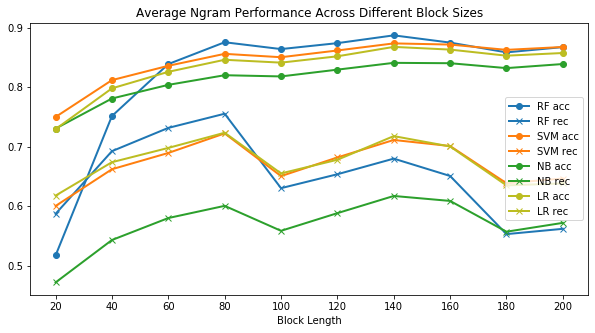

In [5]:
"""
Plot range score comparison
"""
acc_lst = []
rec_lst = []
ranges = [i*10 for i in range(1,11)]
for results in ngrams_ranges.values():
    acc_class = []
    rec_class = []
    for i in range(len(ranges)): 
        indexes = [m*10 + i for m in range(0,5)]
        values = itemgetter(*indexes)(results)
        rec = [m[3] for m in values]
        acc = [m[2] for m in values]
        acc_class.append(sum(acc)/len(acc))
        rec_class.append(sum(rec)/len(rec))
    acc_lst.append(acc_class)
    rec_lst.append(rec_class)
linesnum = [i*2 for i in ranges]
df = pd.DataFrame({'blocksize': linesnum, "RF acc": acc_lst[0], "RF rec": rec_lst[0], "SVM acc": acc_lst[1], "SVM rec": rec_lst[1], "NB acc":acc_lst[2], "NB rec": rec_lst[2], "LR acc": acc_lst[3], "LR rec": rec_lst[3]})
fig= plt.figure(figsize=(10,5))
plt.plot('blocksize', 'RF acc', data=df, marker='o', color = "C0", linewidth=2)
plt.plot('blocksize', 'RF rec', data=df, marker='x', color = "C0", linewidth=2)
plt.plot('blocksize', 'SVM acc', data=df, marker='o',color = "C1", linewidth=2)
plt.plot('blocksize', 'SVM rec', data=df, marker='x',color = "C1", linewidth=2)
plt.plot('blocksize', 'NB acc', data=df, marker='o', color = "C2", linewidth=2)
plt.plot('blocksize', 'NB rec', data=df, marker='x', color = "C2", linewidth=2)
plt.plot('blocksize', 'LR acc', data=df, marker='o', color = "C8", linewidth=2)
plt.plot('blocksize', 'LR rec', data=df, marker='x', color = "C8", linewidth=2)
plt.xticks(linesnum)
plt.xlabel('Block Length')
plt.title('Average Ngram Performance Across Different Block Sizes')
plt.legend()
plt.savefig('ranges.pdf')

### Results ###

In [ ]:
ngrams_ranges = { "RF": [[((1,), (), (), (), 0), 10, 0.47176608886428245, 0.5787600369235562],
 [((1,), (), (), (), 0), 20, 0.7259718562676004, 0.7039093187582096],
 [((1,), (), (), (), 0), 30, 0.8426953053679208, 0.7566177443550306],
 [((1,), (), (), (), 0), 40, 0.8819810843226973, 0.7738210889717815],
 [((1,), (), (), (), 0), 50, 0.8787911483834678, 0.6668020732790344],
 [((1,), (), (), (), 0), 60, 0.8863374854992154, 0.6734845216355927],
 [((1,), (), (), (), 0), 70, 0.9009923319162801, 0.706740164218525],
 [((1,), (), (), (), 0), 80, 0.89639325308282, 0.672704943008491],
 [((1,), (), (), (), 0), 90, 0.8772852236718365, 0.5882101508887694],
 [((1,), (), (), (), 0), 100, 0.8813335641002695, 0.5816940847706127],
 [((2,), (), (), (), 0), 10, 0.5677289878345835, 0.6152098660749138],
 [((2,), (), (), (), 0), 20, 0.7972886812423521, 0.7253339225600195],
 [((2,), (), (), (), 0), 30, 0.8806857829538627, 0.764899155596634],
 [((2,), (), (), (), 0), 40, 0.9160687619911123, 0.7928826604613668],
 [((2,), (), (), (), 0), 50, 0.8957781923278516, 0.6691513024592116],
 [((2,), (), (), (), 0), 60, 0.902433678598694, 0.6901545075250218],
 [((2,), (), (), (), 0), 70, 0.9135261273079562, 0.7151844359413791],
 [((2,), (), (), (), 0), 80, 0.8979317749353672, 0.693783023781031],
 [((2,), (), (), (), 0), 90, 0.8821107766520242, 0.5752340462297528],
 [((2,), (), (), (), 0), 100, 0.8889929612806515, 0.588740131908638],
 [((3,), (), (), (), 0), 10, 0.5677457630174351, 0.6110066017884862],
 [((3,), (), (), (), 0), 20, 0.8023416104582003, 0.7133057027958161],
 [((3,), (), (), (), 0), 30, 0.8703542213467939, 0.7439412418098694],
 [((3,), (), (), (), 0), 40, 0.8978022583035943, 0.7730240134892803],
 [((3,), (), (), (), 0), 50, 0.8850740194781718, 0.6450053849381364],
 [((3,), (), (), (), 0), 60, 0.8915191197290324, 0.66935853373183],
 [((3,), (), (), (), 0), 70, 0.901316179220683, 0.6872970294014957],
 [((3,), (), (), (), 0), 80, 0.8847503636054318, 0.6499043127365067],
 [((3,), (), (), (), 0), 90, 0.8675692853141429, 0.5589338545598789],
 [((3,), (), (), (), 0), 100, 0.8826289139826079, 0.5854075763566332],
 [((4,), (), (), (), 0), 10, 0.5115372585346889, 0.5807637156087133],
 [((4,), (), (), (), 0), 20, 0.7455507682342757, 0.6679760075973122],
 [((4,), (), (), (), 0), 30, 0.8263890802659196, 0.7128834933936725],
 [((4,), (), (), (), 0), 40, 0.866095744021776, 0.7373026350097107],
 [((4,), (), (), (), 0), 50, 0.8505012867551252, 0.6057984665568311],
 [((4,), (), (), (), 0), 60, 0.8632293997076733, 0.6377383983962271],
 [((4,), (), (), (), 0), 70, 0.8756822837535161, 0.6623021943065013],
 [((4,), (), (), (), 0), 80, 0.8639421496136783, 0.637695974572889],
 [((4,), (), (), (), 0), 90, 0.8520232432129443, 0.5443837032790874],
 [((4,), (), (), (), 0), 100, 0.8574968618646821, 0.5481320011782848],
 [((5,), (), (), (), 0), 10, 0.466179221338599, 0.5493265863345622],
 [((5,), (), (), (), 0), 20, 0.6856990713925375, 0.6512752599845202],
 [((5,), (), (), (), 0), 30, 0.7738247738139842, 0.6791141361589842],
 [((5,), (), (), (), 0), 40, 0.8154424290580152, 0.6995252627577796],
 [((5,), (), (), (), 0), 50, 0.809806945756986, 0.5641805424751423],
 [((5,), (), (), (), 0), 60, 0.8263407673721777, 0.5971957984636271],
 [((5,), (), (), (), 0), 70, 0.8437972437118468, 0.6276317510188446],
 [((5,), (), (), (), 0), 80, 0.8314574577547361, 0.5992992097574827],
 [((5,), (), (), (), 0), 90, 0.8132561077026004, 0.49793607859374217],
 [((5,), (), (), (), 0), 100, 0.8261299683318271, 0.5051550364927928]],
  "SVM": [[((1,), (), (), (), 0), 10, 0.7489024914634262, 0.6091067177879002],
 [((1,), (), (), (), 0), 20, 0.8117333986298869, 0.6652016153454398],
 [((1,), (), (), (), 0), 30, 0.840315169943131, 0.6960533315371639],
 [((1,), (), (), (), 0), 40, 0.8696094853077838, 0.7372137741373627],
 [((1,), (), (), (), 0), 50, 0.8686863913394218, 0.6766261012394248],
 [((1,), (), (), (), 0), 60, 0.874678125031755, 0.6808724486695671],
 [((1,), (), (), (), 0), 70, 0.886774664281638, 0.7103749238564097],
 [((1,), (), (), (), 0), 80, 0.887503642610197, 0.7099295980197862],
 [((1,), (), (), (), 0), 90, 0.879066790310542, 0.6499240780964484],
 [((1,), (), (), (), 0), 100, 0.8839410823165984, 0.6618896861543869],
 [((2,), (), (), (), 0), 10, 0.7922850522356037, 0.6330957009956467],
 [((2,), (), (), (), 0), 20, 0.8522660480539365, 0.6988941677000083],
 [((2,), (), (), (), 0), 30, 0.8705002601044942, 0.7263138157979092],
 [((2,), (), (), (), 0), 40, 0.883568617925674, 0.7447143204325873],
 [((2,), (), (), (), 0), 50, 0.8748562902182682, 0.6630348513728601],
 [((2,), (), (), (), 0), 60, 0.8828722236262729, 0.6964680242181236],
 [((2,), (), (), (), 0), 70, 0.8920376464788211, 0.723214253067804],
 [((2,), (), (), (), 0), 80, 0.891033714590469, 0.7157521108188971],
 [((2,), (), (), (), 0), 90, 0.8822731946174924, 0.6516536222030563],
 [((2,), (), (), (), 0), 100, 0.8884267274003286, 0.6639807761334621],
 [((3,), (), (), (), 0), 10, 0.7827147265034843, 0.622804980283086],
 [((3,), (), (), (), 0), 20, 0.8336274497270624, 0.6774814106190886],
 [((3,), (), (), (), 0), 30, 0.8553429907984962, 0.711506555092137],
 [((3,), (), (), (), 0), 40, 0.8719738512215406, 0.741324569322804],
 [((3,), (), (), (), 0), 50, 0.8696743583515504, 0.6767917245266369],
 [((3,), (), (), (), 0), 60, 0.8830015422705042, 0.7160709642408608],
 [((3,), (), (), (), 0), 70, 0.8937700073130829, 0.7453409168368514],
 [((3,), (), (), (), 0), 80, 0.8890414302043107, 0.7228672362127854],
 [((3,), (), (), (), 0), 90, 0.876216131592223, 0.6593277152050316],
 [((3,), (), (), (), 0), 100, 0.8815600054676029, 0.6675918332350191],
 [((4,), (), (), (), 0), 10, 0.7367089383180303, 0.5878978867649534],
 [((4,), (), (), (), 0), 20, 0.8015803942508877, 0.6529017477778357],
 [((4,), (), (), (), 0), 30, 0.8257737966110696, 0.6774653566799105],
 [((4,), (), (), (), 0), 40, 0.8462262938600589, 0.718658928094223],
 [((4,), (), (), (), 0), 50, 0.8368177842637273, 0.6348845584317895],
 [((4,), (), (), (), 0), 60, 0.8482505460227614, 0.6723989861932027],
 [((4,), (), (), (), 0), 70, 0.8602338613110382, 0.7012000106451345],
 [((4,), (), (), (), 0), 80, 0.8607358580678449, 0.7006308051083918],
 [((4,), (), (), (), 0), 90, 0.8504205694633061, 0.6298813835861856],
 [((4,), (), (), (), 0), 100, 0.8542422036668997, 0.6324020267366721],
 [((5,), (), (), (), 0), 10, 0.6885654039060582, 0.5484798039696802],
 [((5,), (), (), (), 0), 20, 0.7598010303874819, 0.6155582923477155],
 [((5,), (), (), (), 0), 30, 0.7875248653012739, 0.6354322361952003],
 [((5,), (), (), (), 0), 40, 0.8085602758976064, 0.6691702359067137],
 [((5,), (), (), (), 0), 50, 0.8014671440657658, 0.6010080810703226],
 [((5,), (), (), (), 0), 60, 0.8193936769203891, 0.6433223598779222],
 [((5,), (), (), (), 0), 70, 0.8349398973414928, 0.675879147049073],
 [((5,), (), (), (), 0), 80, 0.8296283124807218, 0.6558570341337481],
 [((5,), (), (), (), 0), 90, 0.8253208719187779, 0.6016098030991774],
 [((5,), (), (), (), 0), 100, 0.8293691966131019, 0.6059028325660114]],
 "NB": [[((1,), (), (), (), 0), 10, 0.6406166866129281, 0.31029464551007047],
 [((1,), (), (), (), 0), 20, 0.6661217498820762, 0.3342554210160089],
 [((1,), (), (), (), 0), 30, 0.6734412076977818, 0.34033289887405066],
 [((1,), (), (), (), 0), 40, 0.6734251248157388, 0.3313187120941368],
 [((1,), (), (), (), 0), 50, 0.6775869697973939, 0.34237039607856856],
 [((1,), (), (), (), 0), 60, 0.678429050148212, 0.347345104487948],
 [((1,), (), (), (), 0), 70, 0.6814735229359061, 0.3493783421842148],
 [((1,), (), (), (), 0), 80, 0.6820729072733215, 0.3408436300041683],
 [((1,), (), (), (), 0), 90, 0.6805021593426027, 0.3337795619939534],
 [((1,), (), (), (), 0), 100, 0.6833361163039136, 0.3396513756339353],
 [((2,), (), (), (), 0), 10, 0.7823098721374164, 0.4919690929527854],
 [((2,), (), (), (), 0), 20, 0.8271011064028974, 0.5571039779475824],
 [((2,), (), (), (), 0), 30, 0.8533346497538103, 0.5971343485382128],
 [((2,), (), (), (), 0), 40, 0.8664353319913449, 0.6066274775266365],
 [((2,), (), (), (), 0), 50, 0.8657874708632157, 0.5787399672671347],
 [((2,), (), (), (), 0), 60, 0.8741271165245188, 0.5984440477628251],
 [((2,), (), (), (), 0), 70, 0.8855435607010463, 0.62479452008835],
 [((2,), (), (), (), 0), 80, 0.883811022858055, 0.6118963216673855],
 [((2,), (), (), (), 0), 90, 0.8826125387083673, 0.586641756376346],
 [((2,), (), (), (), 0), 100, 0.88577029052705, 0.5894674943755639],
 [((3,), (), (), (), 0), 10, 0.7795246463349196, 0.5218434677760276],
 [((3,), (), (), (), 0), 20, 0.8329472274696569, 0.6078517928843283],
 [((3,), (), (), (), 0), 30, 0.8544522986058596, 0.6457180310390866],
 [((3,), (), (), (), 0), 40, 0.874985726868319, 0.6734780740124275],
 [((3,), (), (), (), 0), 50, 0.8711315479708407, 0.6158894993845553],
 [((3,), (), (), (), 0), 60, 0.8833900908546474, 0.6539861134225136],
 [((3,), (), (), (), 0), 70, 0.8960048238156724, 0.6879598631689658],
 [((3,), (), (), (), 0), 80, 0.8947744282699986, 0.6779071566384223],
 [((3,), (), (), (), 0), 90, 0.884329333263841, 0.615215231381541],
 [((3,), (), (), (), 0), 100, 0.8930900407349533, 0.640225790661566],
 [((4,), (), (), (), 0), 10, 0.745923024148252, 0.5238718437577651],
 [((4,), (), (), (), 0), 20, 0.8065195173430858, 0.6143558322325361],
 [((4,), (), (), (), 0), 30, 0.8344373695584976, 0.6630114930996556],
 [((4,), (), (), (), 0), 40, 0.8547925303627336, 0.6931760921047102],
 [((4,), (), (), (), 0), 50, 0.8517481034661915, 0.6371994808668663],
 [((4,), (), (), (), 0), 60, 0.8683787304999481, 0.6729946183816937],
 [((4,), (), (), (), 0), 70, 0.8825480747514419, 0.7120015660299487],
 [((4,), (), (), (), 0), 80, 0.8794390868709676, 0.6995591062323296],
 [((4,), (), (), (), 0), 90, 0.8676661759591333, 0.6295999608056456],
 [((4,), (), (), (), 0), 100, 0.8764106641859222, 0.6464796767913938],
 [((5,), (), (), (), 0), 10, 0.7031234580163156, 0.5104944583773809],
 [((5,), (), (), (), 0), 20, 0.7718654576314854, 0.6015335745144013],
 [((5,), (), (), (), 0), 30, 0.8034916938653691, 0.653568587282442],
 [((5,), (), (), (), 0), 40, 0.8305999029074339, 0.6976783969884424],
 [((5,), (), (), (), 0), 50, 0.8238308439022296, 0.618238122982924],
 [((5,), (), (), (), 0), 60, 0.8427771843614755, 0.6681376240942326],
 [((5,), (), (), (), 0), 70, 0.8586630989573857, 0.7112272967561225],
 [((5,), (), (), (), 0), 80, 0.8610437168948604, 0.7134350737107484],
 [((5,), (), (), (), 0), 90, 0.8448824278517335, 0.6198022094879734],
 [((5,), (), (), (), 0), 100, 0.8556996633883994, 0.6433807681257215]],
 "LR": [[((1,), (), (), (), 0), 10, 0.7101676226777028, 0.6091455457085401],
 [((1,), (), (), (), 0), 20, 0.7839938899208935, 0.6729613446716908],
 [((1,), (), (), (), 0), 30, 0.8194253759058995, 0.7036878570422508],
 [((1,), (), (), (), 0), 40, 0.846809022331618, 0.7446118042460956],
 [((1,), (), (), (), 0), 50, 0.8394569817979303, 0.6679128192966041],
 [((1,), (), (), (), 0), 60, 0.8524443260015662, 0.690553022175848],
 [((1,), (), (), (), 0), 70, 0.8738035196546887, 0.7313378145325238],
 [((1,), (), (), (), 0), 80, 0.865107540998008, 0.6955474656146269],
 [((1,), (), (), (), 0), 90, 0.854209311511435, 0.6313306703731926],
 [((1,), (), (), (), 0), 100, 0.8633263152650035, 0.6514786316357754],
 [((2,), (), (), (), 0), 10, 0.7735492328474443, 0.6510754100700433],
 [((2,), (), (), (), 0), 20, 0.837206098147407, 0.7118676369510791],
 [((2,), (), (), (), 0), 30, 0.855488876148631, 0.7314162015675449],
 [((2,), (), (), (), 0), 40, 0.8691725871169768, 0.7357903780744547],
 [((2,), (), (), (), 0), 50, 0.8687027757918928, 0.6819090464192724],
 [((2,), (), (), (), 0), 60, 0.878095157926205, 0.700756841600924],
 [((2,), (), (), (), 0), 70, 0.8907746065899038, 0.7368902534906272],
 [((2,), (), (), (), 0), 80, 0.886483221375312, 0.7138936840583021],
 [((2,), (), (), (), 0), 90, 0.8799410259360402, 0.6581705304568325],
 [((2,), (), (), (), 0), 100, 0.8840864903987515, 0.6662730042668791],
 [((3,), (), (), (), 0), 10, 0.765905955262027, 0.6432369184334933],
 [((3,), (), (), (), 0), 20, 0.8256438643365762, 0.6946119234022283],
 [((3,), (), (), (), 0), 30, 0.8480231619200465, 0.716997481132505],
 [((3,), (), (), (), 0), 40, 0.863147995359749, 0.7287100745380349],
 [((3,), (), (), (), 0), 50, 0.8652208659201486, 0.6805400531654332],
 [((3,), (), (), (), 0), 60, 0.873981423917223, 0.7035765377379126],
 [((3,), (), (), (), 0), 70, 0.8895110173183374, 0.7454033775109228],
 [((3,), (), (), (), 0), 80, 0.8824181608334095, 0.7229029329508914],
 [((3,), (), (), (), 0), 90, 0.8684592865171468, 0.6524257454540858],
 [((3,), (), (), (), 0), 100, 0.8708397051559038, 0.6550177619103037],
 [((4,), (), (), (), 0), 10, 0.7232684124316509, 0.6102176781467344],
 [((4,), (), (), (), 0), 20, 0.7896943105133023, 0.6594857257951261],
 [((4,), (), (), (), 0), 30, 0.8176121850187024, 0.6831324822249428],
 [((4,), (), (), (), 0), 40, 0.8405583864933162, 0.721330459762427],
 [((4,), (), (), (), 0), 50, 0.8316031136491103, 0.6398207430170368],
 [((4,), (), (), (), 0), 60, 0.8422259831114005, 0.66405837077462],
 [((4,), (), (), (), 0), 70, 0.8575288952000151, 0.7080881757359491],
 [((4,), (), (), (), 0), 80, 0.8567030970299575, 0.7066837925810866],
 [((4,), (), (), (), 0), 90, 0.8451733764447928, 0.6327043924286695],
 [((4,), (), (), (), 0), 100, 0.8478451907875477, 0.6246928668795535],
 [((5,), (), (), (), 0), 10, 0.6741048960286781, 0.5747498732580892],
 [((5,), (), (), (), 0), 20, 0.7533074192553373, 0.6302661469380018],
 [((5,), (), (), (), 0), 30, 0.7882209894984655, 0.6539235720993268],
 [((5,), (), (), (), 0), 40, 0.8103897424096853, 0.6864529663671662],
 [((5,), (), (), (), 0), 50, 0.8009973655200762, 0.6047046463524393],
 [((5,), (), (), (), 0), 60, 0.8124785227769262, 0.6306995822552133],
 [((5,), (), (), (), 0), 70, 0.8266965601631366, 0.6668137933445959],
 [((5,), (), (), (), 0), 80, 0.8249152177354879, 0.6624493326492928],
 [((5,), (), (), (), 0), 90, 0.816608144302761, 0.599728930392637],
 [((5,), (), (), (), 0), 100, 0.8208344978213175, 0.5934173191847124]]
 }

## Compare different kinds of n-grams with ranges 20, 40 and 70 ##

In [ ]:
lus = ["1g", "2g", "3g", "4g", "5g", "1f", "2f", "3f", "4f", "5f", "1n", "2n", "3n", "4n", "5n", "1a", "2a", "3a", "4a", "5a"]
slices = toext_generator(lus, 1)
rf = BalancedRandomForestClassifier(random_state=42, n_jobs =-1, class_weight = 'balanced')
single_grams20 = compute_results([20], slices, rf)
single_grams40 = compute_results([40], slices, rf)
single_grams70 = compute_results([70], slices, rf)

### Plot the comparison ###

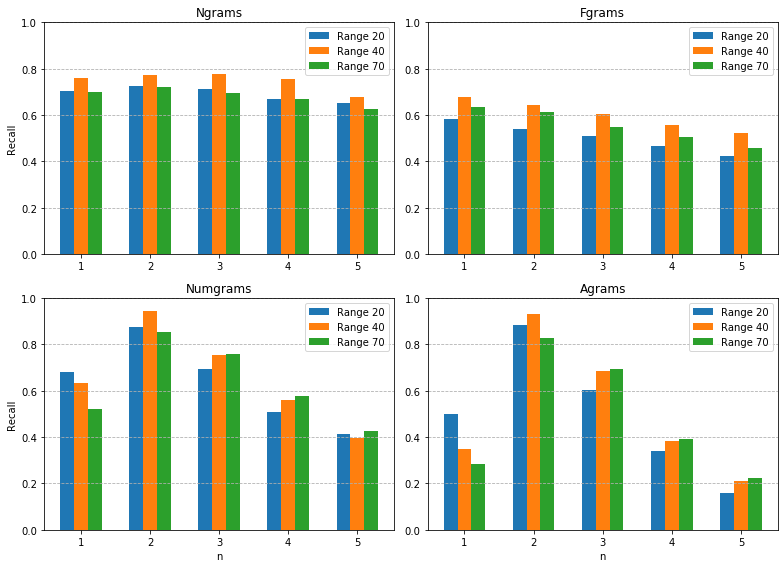

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(11,8))
coordinates = [(0,0), (0,1), (1,0), (1,1)]
for j in range(0,4):
    rec40 = [i[2] for i in single_grams40[j*5:(j+1)*5]]
    rec70 = [i[2] for i in single_grams70[j*5:(j+1)*5]]
    rec20 = [i[2] for i in single_grams20[j*5:(j+1)*5]]
    
    labels = ['1', '2', '3', '4', '5']
    x = np.arange(len(labels))  # the label locations
    width = 0.20  # the width of the bars
    ax = axes[coordinates[j]]
    ax.grid(axis = "y", linestyle = "--")
    rects2 = ax.bar(x - width, rec20, width, label='Range 20')
    rects2 = ax.bar(x, rec40, width, label='Range 40')
    rects2 = ax.bar(x + width, rec70, width, label='Range 70')
    if j == 0:
        ax.set_title('Ngrams')
        ax.set_ylabel('Recall')
    elif j == 1:
        ax.set_title('Fgrams')
    elif j == 2:
        ax.set_title('Numgrams')
        ax.set_xlabel('n')
        ax.set_ylabel('Recall')

    elif j == 3:
        ax.set_title('Agrams')
        ax.set_xlabel('n')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.set_ylim(0,1,0)
    ax.legend()
    fig.tight_layout()
    
plt.savefig('204070.pdf')

### Results ###

In [6]:
single_grams20 = [[((1,), (), (), (), 0), 0.7259718562676004, 0.7039093187582096],
 [((2,), (), (), (), 0), 0.7972886812423521, 0.7253339225600195],
 [((3,), (), (), (), 0), 0.8023416104582003, 0.7133057027958161],
 [((4,), (), (), (), 0), 0.7455507682342757, 0.6679760075973122],
 [((5,), (), (), (), 0), 0.6856990713925375, 0.6512752599845202],
 [((), (1,), (), (), 0), 0.559291646466365, 0.5819199396363446],
 [((), (2,), (), (), 0), 0.49419421463357394, 0.539095589794073],
 [((), (3,), (), (), 0), 0.43949252383963405, 0.5098971650329654],
 [((), (4,), (), (), 0), 0.36890489222626827, 0.4672775151652643],
 [((), (5,), (), (), 0), 0.32341724530492544, 0.42435103353219833],
 [((), (), (1,), (), 0), 0.8282014162665122, 0.6817228780130402],
 [((), (), (2,), (), 0), 0.854792156677638, 0.8751611775534052],
 [((), (), (3,), (), 0), 0.518045181150406, 0.6930558380477752],
 [((), (), (4,), (), 0), 0.34613575979522054, 0.5072767845898125],
 [((), (), (5,), (), 0), 0.27593787386947966, 0.4149680018857326],
 [((), (), (), (1,), 0), 0.6964659866253515, 0.4975968890229253],
 [((), (), (), (2,), 0), 0.8029057320343516, 0.8834168976250096],
 [((), (), (), (3,), 0), 0.5062068963256593, 0.6052284222311948],
 [((), (), (), (4,), 0), 0.23869289280449682, 0.33787101352531207],
 [((), (), (), (5,), 0), 0.060093796270163834, 0.15905088562672964]]

In [7]:
single_grams40 = [[((1,), (), (), (), 0), 0.8777541486420972, 0.7621133481183483],
 [((2,), (), (), (), 0), 0.9076807208319936, 0.7735716461001821],
 [((3,), (), (), (), 0), 0.9045872454721003, 0.7775174386132204],
 [((4,), (), (), (), 0), 0.8681686040927696, 0.7571764019911582],
 [((5,), (), (), (), 0), 0.8171104124729528, 0.6799246271026338],
 [((), (1,), (), (), 0), 0.7441570382112678, 0.6800331866117719],
 [((), (2,), (), (), 0), 0.7032527019235277, 0.6455822346030711],
 [((), (3,), (), (), 0), 0.6671737101390273, 0.6049109332659118],
 [((), (4,), (), (), 0), 0.6078078734138461, 0.556475714711488],
 [((), (5,), (), (), 0), 0.5486698115217604, 0.5243713266141016],
 [((), (), (1,), (), 0), 0.8551803381325644, 0.6345357927501667],
 [((), (), (2,), (), 0), 0.9505282078161155, 0.9444480470610757],
 [((), (), (3,), (), 0), 0.6293581211113394, 0.754124335675754],
 [((), (), (4,), (), 0), 0.4409475696865339, 0.5607791769262931],
 [((), (), (5,), (), 0), 0.35567316714835984, 0.39525095920090025],
 [((), (), (), (1,), 0), 0.6965475928943451, 0.35021220989346785],
 [((), (), (), (2,), 0), 0.9197438132990593, 0.9299935094024463],
 [((), (), (), (3,), 0), 0.5803727069584427, 0.6835182062837621],
 [((), (), (), (4,), 0), 0.2999848755874477, 0.38160300081122034],
 [((), (), (), (5,), 0), 0.16496324872643858, 0.21196640239311662]]

In [8]:
 single_grams70 = [[((1,), (), (), (), 0), 0.8958430207916421, 0.6980956592525851],
 [((2,), (), (), (), 0), 0.9152912452465781, 0.7197914965713064],
 [((3,), (), (), (), 0), 0.9016398350934228, 0.6964853663025294],
 [((4,), (), (), (), 0), 0.8776743019709923, 0.6689873316273072],
 [((5,), (), (), (), 0), 0.8461292366957454, 0.6268043775353616],
 [((), (1,), (), (), 0), 0.8089313596204407, 0.6364088940620025],
 [((), (2,), (), (), 0), 0.7679131110038131, 0.6134841216362881],
 [((), (3,), (), (), 0), 0.7704549026009466, 0.5501078149148529],
 [((), (4,), (), (), 0), 0.7277684476694998, 0.5051743265293435],
 [((), (5,), (), (), 0), 0.6922398612513796, 0.4581033110243],
 [((), (), (1,), (), 0), 0.8302261850324696, 0.5196957684100356],
 [((), (), (2,), (), 0), 0.9492164826595365, 0.8515170241384675],
 [((), (), (3,), (), 0), 0.7135799917199249, 0.7567323836915306],
 [((), (), (4,), (), 0), 0.5087652585622237, 0.5755641594284551],
 [((), (), (5,), (), 0), 0.40428524628961837, 0.42794489838394184],
 [((), (), (), (1,), 0), 0.6603549497049362, 0.28456678149090653],
 [((), (), (), (2,), 0), 0.937168700791983, 0.8266948778077013],
 [((), (), (), (3,), 0), 0.6531775302496445, 0.6956530844880942],
 [((), (), (), (4,), 0), 0.3328897166778608, 0.39224010045294777],
 [((), (), (), (5,), 0), 0.2003461215584504, 0.2213680898011595]]

## Plot the comparison of different Ngrams, range 40 ##

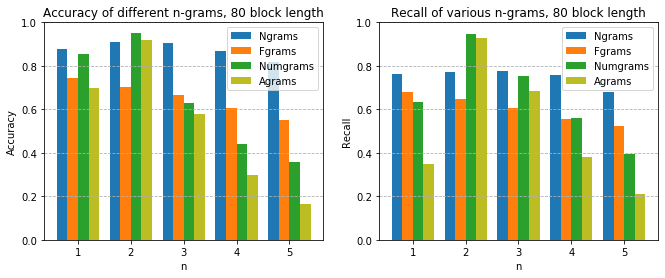

In [10]:
"""Different n-grams range 80 recall and accuracy graph"""
fig, axes = plt.subplots(1, 2, figsize=(11,4))
coordinates = [(0), (1)]
N = 5
single_grams = [i[2] for i in single_grams40[:5]]
single_fgrams = [i[2] for i in single_grams40[5:10]]
single_ngrams = [i[2] for i in single_grams40[10:15]]
single_agrams = [i[2] for i in single_grams40[15:20]]
labels = ['1', '2', '3', '4', '5']
x = np.arange(len(labels))  # the label locations
width = 0.20  # the width of the bars

ax = axes[coordinates[1]]
ax.grid(axis = "y", linestyle = "--")
rects1 = ax.bar(x - width*1.5, single_grams, width, label='Ngrams')
rects2 = ax.bar(x - width/2, single_fgrams, width, label='Fgrams')
rects2 = ax.bar(x + width/2, single_ngrams, width, label='Numgrams')
rects2 = ax.bar(x + width*1.5, single_agrams, width, label='Agrams', color = "C8")

ax.set_ylabel('Recall')
ax.set_xlabel('n')
ax.set_title('Recall of various n-grams, 80 block length')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim(0,1,0)
ax.legend()

#Ngrams accuracy graph

N = 5
single_grams = [i[1] for i in single_grams40[:5]]
single_fgrams = [i[1] for i in single_grams40[5:10]]
single_ngrams = [i[1] for i in single_grams40[10:15]]
single_agrams = [i[1] for i in single_grams40[15:20]]
labels = ['1', '2', '3', '4', '5']
x = np.arange(len(labels))  # the label locations
width = 0.20  # the width of the bars

ax = axes[coordinates[0]]
ax.grid(axis = "y", linestyle = "--")
rects1 = ax.bar(x - width*1.5, single_grams, width, label='Ngrams')
rects2 = ax.bar(x - width/2, single_fgrams, width, label='Fgrams')
rects2 = ax.bar(x + width/2, single_ngrams, width, label='Numgrams')
rects2 = ax.bar(x + width*1.5, single_agrams, width, label='Agrams', color = "C8")

ax.set_ylabel('Accuracy')
ax.set_xlabel('n')
ax.set_title('Accuracy of different n-grams, 80 block length')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim(0,1,0)
ax.legend()
#fig.tight_layout()


## Compare different combinations of 2 n-gram sets, ranges 40 and 70 ##

In [ ]:
lus = ["1g", "2g", "3g", "4g", "5g", "1f", "2f", "3f", "4f", "5f", "1n", "2n", "3n", "4n", "5n", "1a", "2a", "3a", "4a", "5a"]
slices2 = toext_generator(lus, 2, 0) + toext_generator(lus, 2, 1)
"""
Low-n n-grams were prefered and computed first, as they performed better. 
Not all combinations were computed.
"""
rf = BalancedRandomForestClassifier(random_state=42, n_jobs =-1, class_weight = 'balanced')
grams_combs40 = compute_results([40], slices2, rf)
grams_combs40 = compute_results([70], slices2, rf)

In [21]:
grams_combs40 = [[((1, 2), (), (), (), 0), 0.9077613279850475, 0.7675497935299334],
 [((1,), (), (1,), (), 0), 0.8768153402320846, 0.7037005726249531],
 [((1,), (), (2,), (), 0), 0.9608275197438487, 0.9344477869634066],
 [((1,), (), (3,), (), 0), 0.9391928310153383, 0.8984524972601138],
 [((1,), (), (), (1,), 0), 0.8619492463525548, 0.6215645399359522],
 [((1,), (), (), (2,), 0), 0.9768918407826146, 0.9514885241530898],
 [((1,), (), (), (3,), 0), 0.9218010939795069, 0.8535639183713493],
 [((2,), (), (1,), (), 0), 0.8956485209773373, 0.7323175320066202],
 [((2,), (), (2,), (), 0), 0.9584310772259584, 0.9201981526413118],
 [((2,), (), (3,), (), 0), 0.9472412330690331, 0.8832341814429444],
 [((2,), (), (), (1,), 0), 0.8985792348437094, 0.7310109969008836],
 [((2,), (), (), (2,), 0), 0.9717423303592589, 0.9158530874602654],
 [((2,), (), (), (3,), 0), 0.94222135728327, 0.8640082306670264],
 [((), (), (1, 2), (), 0), 0.9373789937184845, 0.8837334999733871],
 [((), (), (1, 3), (), 0), 0.9136718658064042, 0.8297182246308383],
 [((), (), (1,), (1,), 0), 0.8538847286374228, 0.6124643179219506],
 [((), (), (1,), (2,), 0), 0.9516944488423466, 0.9032182351900243],
 [((), (), (1,), (3,), 0), 0.8974459253082164, 0.7778878431700724],
 [((), (), (2, 3), (), 0), 0.936569441016266, 0.9252521876627199],
 [((), (), (2,), (1,), 0), 0.9383178899772741, 0.9072552118949442],
 [((), (), (2,), (2,), 0), 0.9759686825666396, 0.9584103525190631],
 [((), (), (2,), (3,), 0), 0.943095245447188, 0.9348833632456961],
 [((), (), (3,), (1,), 0), 0.8620782214687331, 0.8007447149589062],
 [((), (), (3,), (2,), 0), 0.9308370434690826, 0.9412497039521084],
 [((), (), (3,), (3,), 0), 0.6743916265692725, 0.8091664407371628],
 [((), (), (), (1, 2), 0), 0.9358079599514472, 0.8801671335506706],
 [((), (), (), (1, 3), 0), 0.8086392152350758, 0.6698247006187628],
 [((), (), (), (2, 3), 0), 0.9143674760226924, 0.9331121456080924],
 [((1, 3), (), (), (), 0), 0.9037774213564965, 0.7744148840543106],
 [((1, 4), (), (), (), 0), 0.9059798688627551, 0.7712898123642263],
 [((1,), (2,), (), (), 0), 0.8859481069408073, 0.7664193541200617],
 [((1,), (3,), (), (), 0), 0.873608973949232, 0.7341165484483353],
 [((1,), (4,), (), (), 0), 0.8796329691214826, 0.7680363336067527],
 [((2, 3), (), (), (), 0), 0.9078746319283757, 0.7589618224858192],
 [((2, 4), (), (), (), 0), 0.9000047044986769, 0.7591330141170525],
 [((2,), (2,), (), (), 0), 0.8976080548150144, 0.7608879100133343],
 [((2,), (3,), (), (), 0), 0.90876543032625, 0.7725767254927438],
 [((2,), (4,), (), (), 0), 0.9091055230984919, 0.7922892382204345],
 [((3, 4), (), (), (), 0), 0.8881348347607119, 0.7509286533550631],
 [((3,), (2,), (), (), 0), 0.899761620377245, 0.7625219969126287],
 [((3,), (3,), (), (), 0), 0.8918107239099786, 0.7488671549540475],
 [((3,), (4,), (), (), 0), 0.8911630909264341, 0.7534932723015748],
 [((3,), (), (1,), (), 0), 0.8999071425316902, 0.7430281582473831],
 [((3,), (), (2,), (), 0), 0.9388692708584301, 0.8668917343754913],
 [((3,), (), (3,), (), 0), 0.9312906342386673, 0.8552449460703032],
 [((3,), (), (), (1,), 0), 0.8856568934902418, 0.7150991377677366],
 [((3,), (), (), (2,), 0), 0.9675157539408208, 0.9199283098619022],
 [((4,), (2,), (), (), 0), 0.8809934424821606, 0.7399910834675578],
 [((4,), (3,), (), (), 0), 0.8640389628992982, 0.7219469731205589],
 [((4,), (4,), (), (), 0), 0.8642494433239355, 0.7327481812613661],
 [((4,), (), (1,), (), 0), 0.8934785880079208, 0.7469721559690795],
 [((4,), (), (2,), (), 0), 0.9357758781026106, 0.8821910021698868],
 [((4,), (), (3,), (), 0), 0.898240132009177, 0.8302975784781713],
 [((4,), (), (), (1,), 0), 0.8650749504129711, 0.7028611271164823],
 [((4,), (), (), (2,), 0), 0.9477109604788676, 0.8870999033490927],
 [((), (2, 3), (), (), 0), 0.7199319237538175, 0.6262775698634159],
 [((), (2, 4), (), (), 0), 0.7288223169983777, 0.6520285734078461],
 [((), (2,), (1,), (), 0), 0.8819161142519235, 0.7258134753632203],
 [((), (2,), (2,), (), 0), 0.943338619338466, 0.9013818846245547],
 [((), (2,), (3,), (), 0), 0.9052352180501702, 0.8471512418562923],
 [((), (2,), (), (1,), 0), 0.8478116548447782, 0.6130816006020059],
 [((), (2,), (), (2,), 0), 0.9609250764661322, 0.927352150555817],
 [((), (3, 4), (), (), 0), 0.6732133515717884, 0.5995730663914476],
 [((), (3,), (1,), (), 0), 0.8775113975593118, 0.7180139639074934],
 [((), (3,), (2,), (), 0), 0.9471442165511684, 0.9076841295820784],
 [((), (3,), (3,), (), 0), 0.8742889890408652, 0.8153215152845401],
 [((), (3,), (), (1,), 0), 0.8327843309250312, 0.6549946678174485],
 [((), (3,), (), (2,), 0), 0.9562610970542142, 0.9278721391342526],
 [((), (4,), (1,), (), 0), 0.8746774799332743, 0.7332093665666227],
 [((), (4,), (2,), (), 0), 0.9407801286066759, 0.8971438199462783],
 [((), (4,), (3,), (), 0), 0.8415615513438404, 0.7940809817049508],
 [((), (4,), (), (1,), 0), 0.8037817207018593, 0.5889900194844232],
 [((), (4,), (), (2,), 0), 0.9500103773006627, 0.9009381408860302],
 [((1, 2), (), (), (), 1), 0.9102065121511576, 0.7856803137895092],
 [((1, 3), (), (), (), 1), 0.9078259545277685, 0.7734459573488742],
 [((1, 4), (), (), (), 1), 0.901963716488396, 0.7564506388729466],
 [((1,), (2,), (), (), 1), 0.8942557874479176, 0.7578471544837435],
 [((1,), (3,), (), (), 1), 0.89011037149871, 0.7595041414083687],
 [((1,), (4,), (), (), 1), 0.8782569098143801, 0.7402450089823087],
 [((1,), (), (1,), (), 1), 0.8836812413687756, 0.6971272647278194],
 [((1,), (), (2,), (), 1), 0.9616370580231337, 0.9304935149258762],
 [((1,), (), (3,), (), 1), 0.9454111686608012, 0.9087593780186909],
 [((1,), (), (), (1,), 1), 0.8705481875125587, 0.6581030220097535],
 [((1,), (), (), (2,), 1), 0.97838127090301, 0.9509044926594494],
 [((2, 3), (), (), (), 1), 0.9160846442632617, 0.7864983707759373],
 [((2, 4), (), (), (), 1), 0.9068705925236102, 0.7639107623818653],
 [((2,), (2,), (), (), 1), 0.9100447051936001, 0.7746861386545806],
 [((2,), (3,), (), (), 1), 0.9076157140482979, 0.7740427584664078],
 [((2,), (4,), (), (), 1), 0.9046198059000943, 0.7691587248630691],
 [((2,), (), (1,), (), 1), 0.9025953255928073, 0.7408487542281879],
 [((2,), (), (2,), (), 1), 0.9657988440018789, 0.9302795876109899],
 [((2,), (), (3,), (), 1), 0.9496055609586923, 0.9027326915166448],
 [((2,), (), (), (1,), 1), 0.9020125669642052, 0.7352570689565165],
 [((2,), (), (), (2,), 1), 0.9688921961112493, 0.9230061508770548],
 [((3, 4), (), (), (), 1), 0.8960534500804244, 0.7561461469601245],
 [((3,), (2,), (), (), 1), 0.9092509678935666, 0.7748749131430385],
 [((3,), (3,), (), (), 1), 0.9054941555978846, 0.7756815943517129],
 [((3,), (4,), (), (), 1), 0.9058344240676803, 0.7682496312888034],
 [((3,), (), (1,), (), 1), 0.9017208211762755, 0.7430989013390773],
 [((3,), (), (2,), (), 1), 0.9485851620137955, 0.8970222728472734],
 [((3,), (), (3,), (), 1), 0.9391285440671426, 0.8754972671797404],
 [((3,), (), (), (1,), 1), 0.8930247507372904, 0.7293498604764552],
 [((3,), (), (), (2,), 1), 0.965912462627393, 0.9061968339390845],
 [((4,), (2,), (), (), 1), 0.8931708602984825, 0.748822780826783],
 [((4,), (3,), (), (), 1), 0.8821432557871202, 0.7303942664116332],
 [((4,), (4,), (), (), 1), 0.8733825430713047, 0.7266210296278416],
 [((4,), (), (1,), (), 1), 0.9016723548749679, 0.7543970661055813],
 [((4,), (), (2,), (), 1), 0.9351932073227855, 0.8631411944850844],
 [((4,), (), (3,), (), 1), 0.9133804910812184, 0.8557683762116637],
 [((4,), (), (), (1,), 1), 0.8721836760582911, 0.7095490200791271],
 [((4,), (), (), (2,), 1), 0.9563745360486473, 0.9029781056088628],
 [((), (2, 3), (), (), 1), 0.8349550728899002, 0.70368864807578],
 [((), (2, 4), (), (), 1), 0.8292710760852356, 0.7115441876344425],
 [((), (2,), (1,), (), 1), 0.8749849663863701, 0.6945020486600761],
 [((), (2,), (2,), (), 1), 0.9512408816739256, 0.910304042555115],
 [((), (2,), (3,), (), 1), 0.9187890885263268, 0.8702796890749666],
 [((), (2,), (), (1,), 1), 0.8563301186581296, 0.6429646788391268],
 [((), (2,), (), (2,), 1), 0.9633863841607344, 0.928569495004173],
 [((), (3, 4), (), (), 1), 0.7967542407521954, 0.6614809455438534],
 [((), (3,), (1,), (), 1), 0.8933809539262667, 0.7325958607922413],
 [((), (3,), (2,), (), 1), 0.948180346983001, 0.9012167250212464],
 [((), (3,), (3,), (), 1), 0.8872603421447623, 0.8314491483095882],
 [((), (3,), (), (1,), 1), 0.8441686748962616, 0.6275575788075821],
 [((), (3,), (), (2,), 1), 0.9541397628148583, 0.9148414681915404],
 [((), (4,), (1,), (), 1), 0.8792766203919957, 0.7235234150218438],
 [((), (4,), (2,), (), 1), 0.9486985656064826, 0.9116838296182734],
 [((), (4,), (3,), (), 1), 0.8776411252903845, 0.8260379576036193],
 [((), (4,), (), (1,), 1), 0.8345015253891159, 0.6320288285297483],
 [((), (4,), (), (2,), 1), 0.9534429397609792, 0.9201332478306352],
 [((), (), (1, 2), (), 1), 0.9471276301776284, 0.8954641312649348],
 [((), (), (1, 3), (), 1), 0.9214609068026093, 0.8551895844645891],
 [((), (), (1,), (1,), 1), 0.8623701429542168, 0.646341393678656],
 [((), (), (1,), (2,), 1), 0.9590461419144543, 0.9233981955847597],
 [((), (), (2, 3), (), 1), 0.9396298813025352, 0.9395273999388458],
 [((), (), (2,), (1,), 1), 0.9418645116181645, 0.9163079472985689],
 [((), (), (2,), (2,), 1), 0.975207524051061, 0.9546196305174213],
 [((), (), (3,), (1,), 1), 0.8766527255902503, 0.8008548598336749],
 [((), (), (3,), (2,), 1), 0.9327963884974484, 0.9449519942460644],
 [((), (), (), (1, 2), 1), 0.938900938375722, 0.9026443989234736]]

In [22]:
single_grams40_simplem = [[((1,), (), (), (), 1), 0.8777060481588306, 0.7417934896981577],
 [((2,), (), (), (), 1), 0.9118257250720081, 0.7767073944056807],
 [((3,), (), (), (), 1), 0.9083604776219992, 0.7782257562437227],
 [((4,), (), (), (), 1), 0.8691398496802535, 0.7216894720380214],
 [((5,), (), (), (), 1), 0.845675463672728, 0.7250057274865336],
 [((), (1,), (), (), 1), 0.8459827796729732, 0.7222894464735795],
 [((), (2,), (), (), 1), 0.8335300451011687, 0.7303731345721454],
 [((), (3,), (), (), 1), 0.8109724131895104, 0.6859186908870021],
 [((), (4,), (), (), 1), 0.7625696134358805, 0.6441415550374332],
 [((), (5,), (), (), 1), 0.7092940505071464, 0.6023108129046091],
 [((), (), (1,), (), 1), 0.8601842201962372, 0.6683111849991479],
 [((), (), (2,), (), 1), 0.950042373923074, 0.9415332552716228],
 [((), (), (3,), (), 1), 0.7144563291601888, 0.8382137542245605],
 [((), (), (4,), (), 1), 0.5402311078419129, 0.6741244528854595],
 [((), (), (5,), (), 1), 0.482145785045188, 0.6259920630997325],
 [((), (), (), (1,), 1), 0.7424242341995944, 0.3937176317849329],
 [((), (), (), (2,), 1), 0.9461240457508563, 0.9406006277132632],
 [((), (), (), (3,), 1), 0.6530179037773991, 0.7550456354139359],
 [((), (), (), (4,), 1), 0.44569518900107086, 0.558094652354382],
 [((), (), (), (5,), 1), 0.3375225294416325, 0.4623897888317747]]

In [23]:
 grams_combs70 = [[((1, 2), (), (), (), 1), 0.9069029444746561, 0.7010773427009872],
 [((1, 3), (), (), (), 1), 0.8984499843806185, 0.6914062871581582],
 [((1, 4), (), (), (), 1), 0.9009276516153522, 0.7096216411575581],
 [((1,), (2,), (), (), 1), 0.8944664173465933, 0.6867198976055803],
 [((1,), (3,), (), (), 1), 0.8988710842145254, 0.6890603389657413],
 [((1,), (4,), (), (), 1), 0.8802323272353826, 0.659306584988415],
 [((1,), (), (1,), (), 1), 0.8595042719745685, 0.5950898758147869],
 [((1,), (), (2,), (), 1), 0.9522932247942026, 0.8541058318964678],
 [((1,), (), (3,), (), 1), 0.9443586314865096, 0.8483379497927096],
 [((1,), (), (), (1,), 1), 0.8276672589903227, 0.5217708546747027],
 [((1,), (), (), (2,), 1), 0.9586412351013556, 0.8645549458498302],
 [((2, 3), (), (), (), 1), 0.9071296152977502, 0.7019110323729553],
 [((2, 4), (), (), (), 1), 0.9083767689809902, 0.7190641431472593],
 [((2,), (2,), (), (), 1), 0.9053160022119535, 0.695505817003035],
 [((2,), (3,), (), (), 1), 0.9019477463674695, 0.6896360615871842],
 [((2,), (4,), (), (), 1), 0.9069193354830061, 0.7082173931047545],
 [((2,), (), (1,), (), 1), 0.8946442521168112, 0.6731213590830041],
 [((2,), (), (2,), (), 1), 0.9517752054694387, 0.8424903138625256],
 [((2,), (), (3,), (), 1), 0.9340757931711998, 0.8135600462850346],
 [((2,), (), (), (1,), 1), 0.8800697558623488, 0.6370415744839091],
 [((2,), (), (), (2,), 1), 0.9565684904138301, 0.8548302158754989],
 [((3, 4), (), (), (), 1), 0.9010575419322209, 0.6973593625963787],
 [((3,), (2,), (), (), 1), 0.9025305626878055, 0.6957737402340554],
 [((3,), (3,), (), (), 1), 0.8957133087946788, 0.6796406441867101],
 [((3,), (4,), (), (), 1), 0.8927659836424267, 0.6717628329789995],
 [((3,), (), (1,), (), 1), 0.8993405310327443, 0.6805757819995655],
 [((3,), (), (2,), (), 1), 0.9450711899608517, 0.8146385396686793],
 [((3,), (), (3,), (), 1), 0.9306105640776516, 0.7960567798734669],
 [((3,), (), (), (1,), 1), 0.8889926583990478, 0.6603498537083954],
 [((3,), (), (), (2,), 1), 0.9509006984305554, 0.8287904259083234],
 [((4,), (2,), (), (), 1), 0.8891387954949312, 0.6865213067090326],
 [((4,), (3,), (), (), 1), 0.8842481662387316, 0.6715821591720046],
 [((4,), (4,), (), (), 1), 0.8766699046152404, 0.661765293978595],
 [((4,), (), (1,), (), 1), 0.8911625690784761, 0.6861031946383196],
 [((4,), (), (2,), (), 1), 0.9351607281876897, 0.8021750429111897],
 [((4,), (), (3,), (), 1), 0.9153076506778615, 0.7793883687594765],
 [((4,), (), (), (1,), 1), 0.8818836652738702, 0.661948101796604],
 [((4,), (), (), (2,), 1), 0.9410389022574186, 0.810476299918667],
 [((), (2, 3), (), (), 1), 0.8660303438853483, 0.6443546103539187],
 [((), (2, 4), (), (), 1), 0.8643136725803972, 0.6384494486240726],
 [((), (2,), (1,), (), 1), 0.862014279359766, 0.6036526709868226],
 [((), (2,), (2,), (), 1), 0.9406986390323262, 0.8254707829160207],
 [((), (2,), (3,), (), 1), 0.9246672586625287, 0.8078443526783484],
 [((), (2,), (), (1,), 1), 0.8329301218705101, 0.5449084564881119],
 [((), (2,), (), (2,), 1), 0.9584146023023591, 0.8583161408299518],
 [((), (3, 4), (), (), 1), 0.8270199642901279, 0.5760676457678656],
 [((), (3,), (1,), (), 1), 0.870370192778896, 0.6222549722530625],
 [((), (3,), (2,), (), 1), 0.937379085500789, 0.8059694262098954],
 [((), (3,), (3,), (), 1), 0.9087653070757273, 0.7726240033024979],
 [((), (3,), (), (1,), 1), 0.826922625223023, 0.5538612620822208],
 [((), (3,), (), (2,), 1), 0.9497186000445144, 0.8279845734511774],
 [((), (4,), (1,), (), 1), 0.8690260828918769, 0.6307206536902803],
 [((), (4,), (2,), (), 1), 0.9378648066327138, 0.8155555115421762],
 [((), (4,), (3,), (), 1), 0.8993405664344902, 0.7380558010451324],
 [((), (4,), (), (1,), 1), 0.8197165290423796, 0.5520601917347341],
 [((), (4,), (), (2,), 1), 0.9453947225830687, 0.8096394467134648],
 [((), (), (1, 2), (), 1), 0.920084434475138, 0.792126197321491],
 [((), (), (1, 3), (), 1), 0.9112105318882865, 0.7806390794036904],
 [((), (), (1,), (1,), 1), 0.8159756173753079, 0.47962727542506756],
 [((), (), (1,), (2,), 1), 0.9368123350172108, 0.8117055772722971],
 [((), (), (2, 3), (), 1), 0.9520016796161664, 0.8491139078165079],
 [((), (), (2,), (1,), 1), 0.9239868003934838, 0.7973551657192326],
 [((), (), (2,), (2,), 1), 0.9626894352339811, 0.8764977224236267],
 [((), (), (3,), (1,), 1), 0.8587104140463637, 0.7145051511194883],
 [((), (), (3,), (2,), 1), 0.9592078662679381, 0.8716340896235829],
 [((), (), (), (1, 2), 1), 0.9221403515327807, 0.7887176219886833],
  [((1,), (), (), (2,), 0), 0.961604809654974, 0.8602695569391937],
 [((), (), (2,), (2,), 0), 0.9639365692495845, 0.874733619604503],
 [((), (), (3,), (2,), 0), 0.9437922730444879, 0.8544771546734637],
  [((), (), (2,), (), 0), 0.9443098727930043, 0.8383741907282392],
 [((), (), (), (2,), 0), 0.9432738800346282, 0.8303475964421312]]

In [24]:
"""
Best range 40 combinations
"""
comb = grams_combs40 + single_grams40 + single_grams40_simplem
df40 = pd.DataFrame(comb, columns = ["grams", "acc", "recall"])
df40.sort_values(["recall"], ascending = 0).iloc[:20]


,grams,acc,recall
20,"((), (), (2,), (2,), 0)",0.975969,0.958410
135,"((), (), (2,), (2,), 1)",0.975208,0.954620
5,"((1,), (), (), (2,), 0)",0.976892,0.951489
83,"((1,), (), (), (2,), 1)",0.978381,0.950904
137,"((), (), (3,), (2,), 1)",0.932796,0.944952
150,"((), (), (2,), (), 0)",0.950528,0.944448
170,"((), (), (2,), (), 1)",0.950042,0.941533
23,"((), (), (3,), (2,), 0)",0.930837,0.941250
175,"((), (), (), (2,), 1)",0.946124,0.940601
133,"((), (), (2, 3), (), 1)",0.939630,0.939527


In [25]:
"""
Best range 70 combinations for reference
"""
comb = single_grams70 + grams_combs70
df70 = pd.DataFrame(comb, columns = ["grams", "acc", "recall"])
df70.sort_values(["recall"], ascending = 0).iloc[:10]

,grams,acc,recall
82,"((), (), (2,), (2,), 1)",0.962689,0.876498
87,"((), (), (2,), (2,), 0)",0.963937,0.874734
84,"((), (), (3,), (2,), 1)",0.959208,0.871634
30,"((1,), (), (), (2,), 1)",0.958641,0.864555
86,"((1,), (), (), (2,), 0)",0.961605,0.860270
64,"((), (2,), (), (2,), 1)",0.958415,0.858316
40,"((2,), (), (), (2,), 1)",0.956568,0.854830
88,"((), (), (3,), (2,), 0)",0.943792,0.854477
27,"((1,), (), (2,), (), 1)",0.952293,0.854106
11,"((), (), (2,), (), 0)",0.949216,0.851517


## Comparing classifiers with numgrams, range 40

In [ ]:
slices = toext_generator(["1n", "2n", "3n", "4n", "5n"], 1)
slices = [((), (), (), (2,), 0)]
classifiers_comparison = {}
for name, classifier in classifiers.items():
    res = compute_results([40], slices, classifier)
    classifiers_comparison[name] = res


### Plotting the classifier comparison

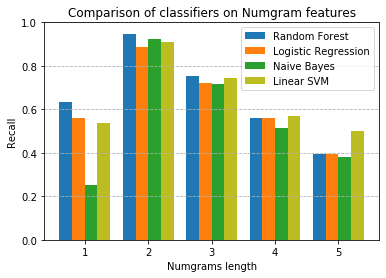

In [28]:
rf_rec = [i[2] for i in classifiers_comparison["RF"]]
lr_rec = [i[2] for i in classifiers_comparison["LR"]]
nb_rec = [i[2] for i in classifiers_comparison["NB"]]
svm_rec = [i[2] for i in classifiers_comparison["SVC"]]

labels = ['1', '2', '3', '4', '5']
x = np.arange(len(labels))  # the label locations
width = 0.20  # the width of the bars

fig, ax = plt.subplots()
ax.grid(axis = "y", linestyle = "--")
rects1 = ax.bar(x - width*1.5, rf_rec, width, label='Random Forest')
rects2 = ax.bar(x - width/2, lr_rec, width, label='Logistic Regression')
rects2 = ax.bar(x + width/2, nb_rec, width, label='Naive Bayes')
rects1 = ax.bar(x + width*1.5, svm_rec, width, label='Linear SVM', color="C8")

ax.set_ylabel('Recall')
ax.set_xlabel('Numgrams length')
ax.set_title('Comparison of classifiers on Numgram features')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim(0,1,0)
ax.legend()
#fig.tight_layout()

plt.savefig('classifiers.pdf')

### Results

In [27]:
classifiers_comparison = {"RF": [[((), (), (1,), (), 0), 0.8551803381325644, 0.6345357927501667],
 [((), (), (2,), (), 0), 0.9505282078161155, 0.9444480470610757],
 [((), (), (3,), (), 0), 0.6293581211113394, 0.754124335675754],
 [((), (), (4,), (), 0), 0.4409475696865339, 0.5607791769262931],
 [((), (), (5,), (), 0), 0.35567316714835984, 0.39525095920090025]],
 "LR": [[((), (), (1,), (), 0), 0.7742128805318915, 0.5607741861079312],
 [((), (), (2,), (), 0), 0.9297357240001218, 0.8866483462806455],
 [((), (), (3,), (), 0), 0.7379693256983567, 0.7208139376503884],
 [((), (), (4,), (), 0), 0.46548061115214, 0.557908022425725],
 [((), (), (5,), (), 0), 0.3602071906846206, 0.3924465159106154]],
 "NB": [[((), (), (1,), (), 0), 0.5215940658806824, 0.2534858085332089],
 [((), (), (2,), (), 0), 0.9425286247700116, 0.9212540170025839],
 [((), (), (3,), (), 0), 0.782988951049547, 0.7154838225778016],
 [((), (), (4,), (), 0), 0.6401144472886032, 0.5161469412977763],
 [((), (), (5,), (), 0), 0.5754371174849551, 0.37970206330849415]],
 "SVC": [[((), (), (1,), (), 0), 0.7536149017749059, 0.5386944037077439],
 [((), (), (2,), (), 0), 0.9387558410422274, 0.908660795769693],
 [((), (), (3,), (), 0), 0.69306336879736, 0.7435520763980277],
 [((), (), (4,), (), 0), 0.5490543413521566, 0.571532293361613],
 [((), (), (5,), (), 0), 0.5945294206537064, 0.5010848082116619]]
 }

## Hyperparameters tuning

In [ ]:
"""
Random grid search
"""
start = timer()
random_grid = {'bootstrap': [True, False],
               'max_depth': [10, 30, 50, 70, 90, 110, None],
               'max_features': ['auto', 'sqrt'],
               'min_samples_leaf': [1, 4, 7, 10],
               'min_samples_split': [2, 5, 10],
               'class_weight': ['balanced', 'balanced_subsample'],
               'n_estimators': [50, 100, 200]}
brf = BalancedRandomForestClassifier(n_jobs = -1, random_state = 42)
clf = RandomizedSearchCV(brf, random_grid, n_iter=150, cv=5, random_state=42, n_jobs=-1,scoring='recall_macro', verbose = 3)
model = clf.fit(df_train, y_train)
stop = timer()
print(stop-start)


### Hyperparameter tuning results ###

Accuracy:  0.970
Recall macro:  0.966

Accuracy:  0.976
Recall macro:  0.958
280.1752940000151

best_params = {'n_estimators': 200,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 110,
 'class_weight': 'balanced_subsample',
 'bootstrap': False}

## Interpreting the results

### Feature importances

In [29]:
pipe = make_pipeline(FeaturesExtractor(toext=((), (), (2,), (2,), 0), rang=40), BalancedRandomForestClassifier(random_state=42, n_jobs =-1, n_estimators = 200, min_samples_split = 2, min_samples_leaf = 4, max_features = 'auto', max_depth = 110, class_weight = 'balanced_subsample', bootstrap = False))
pipe.fit(X_train,y_train)
rfm_guess = pipe.predict(X_test)
print(20*"-")
accuracy = accuracy_score(y_test, rfm_guess)
recall = recall_score(y_test, rfm_guess, average='macro')
print("RF Accuracy: ", accuracy)
print("RF Recall: ", recall)
importances = list(pipe[1].feature_importances_)
fe = FeaturesExtractor(toext=((), (), (2,), (2,), 0), rang=40)
to_obtain_columns = fe.transform(X_train[:1000])
feature_list = list(to_obtain_columns.columns)
feature_importances = [(feature, round(importance, 5)) for feature, importance in zip(feature_list, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
top = [pair for pair in feature_importances[:20]]
top

Processed lines: 1000
Processed lines: 2000
Processed lines: 3000
Processed lines: 4000
Processed lines: 5000
Processed lines: 6000
Processed lines: 7000
Processed lines: 8000
Processed lines: 9000
Processed lines: 10000
Processed lines: 11000
Processed lines: 12000
Processed lines: 13000
Processed lines: 14000
Processed lines: 15000
Processed lines: 16000
Processed lines: 17000
Processed lines: 18000
Processed lines: 19000
Processed lines: 20000
Processed lines: 21000
Processed lines: 22000
Processed lines: 23000
Processed lines: 24000
Processed lines: 25000
Processed lines: 26000
Processed lines: 27000
Processed lines: 28000
Processed lines: 29000
Processed lines: 30000
Processed lines: 31000
Processed lines: 32000
Processed lines: 33000
Processed lines: 34000
Processed lines: 35000
Processed lines: 36000
Processed lines: 37000
Processed lines: 38000
Processed lines: 39000
Processed lines: 40000
Processed lines: 41000
Processed lines: 42000
Processed lines: 43000
Processed lines: 440

[('a40 ; 0', 0.01299),
 ('n40 1 3', 0.01066),
 ('n40 ; 0', 0.01057),
 ('n40 cd 4', 0.00896),
 ('n40 clear cd', 0.00869),
 ('a40 5 4', 0.0086),
 ('a40 0 1', 0.00854),
 ('n40 1 0', 0.00815),
 ('a40 5 3', 0.00775),
 ('n40 0 1', 0.00765),
 ('a40 4 7', 0.00751),
 ('n40 git 0', 0.00732),
 ('n40 4 2', 0.00726),
 ('n40 cd clear', 0.00678),
 ('a40 3 2', 0.00677),
 ('n40 sudo 5', 0.00668),
 ('n40 3 13', 0.00654),
 ('a40 2 4', 0.00647),
 ('n40 2 1', 0.00646),
 ('a40 0 3', 0.00637)]

### Results by user

In [30]:
print("RF Recall: ", recall)
bounds = np.where(np.roll(y_test,1)!=y_test)[0]
bounds = np.append(bounds, len(y_test)+1)

lex_divs, lens, hitrates, lst = [], [], [], []
for i, userbound in enumerate(bounds):
    if userbound +1 <  bounds[-1:]:
        upper_bound = bounds[bounds >= (userbound+1)].min()
        lower_bound = bounds[bounds < userbound+1].max()
        section = rfm_guess[lower_bound:upper_bound]
        bincounts = np.bincount(section)
        counts = {"user " + str(m): bincounts[m] for m in range(len(bincounts)) if bincounts[m] > 0}
        try:
            hitrate = bincounts[i]/sum(bincounts)
        except IndexError:
            hitrate = 0
        sp = " ".join(flj_short[i]).split()
        lex_dive = len(set(sp))/(len(sp))
        lens.append(len(flj_short[i]))
        lex_divs.append(lex_dive)
        hitrates.append(hitrate)
        lst.append([len(flj_short[i]), hitrate, lex_dive, counts])
overview = pd.DataFrame(lst, columns = ["n_lines", "recall", "lexical diversity", "predicted: number"]).sort_values(['recall'], ascending = 0)
pd.set_option('display.max_colwidth', -1)
overview

RF Recall:  0.8526940529530321


,n_lines,recall,lexical diversity,predicted: number
0,916,1.000000,0.140929,{'user 0': 183}
13,4002,1.000000,0.086122,{'user 13': 800}
28,4132,1.000000,0.103878,{'user 28': 826}
27,501,1.000000,0.182727,{'user 27': 100}
26,505,1.000000,0.219366,{'user 26': 101}
24,942,1.000000,0.239275,{'user 24': 188}
23,10947,1.000000,0.114080,{'user 23': 2190}
20,3608,1.000000,0.209581,{'user 20': 721}
19,501,1.000000,0.178958,{'user 19': 100}
18,501,1.000000,0.191680,{'user 18': 100}


### Correlations between n_lines lex_div and lex_div and hitrates


-0.06578889457362695
0.2634089796592727
0.1494127742414527


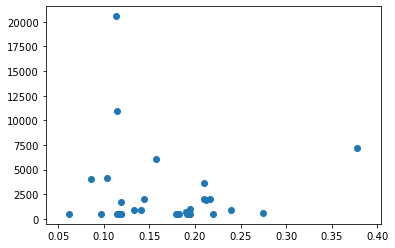

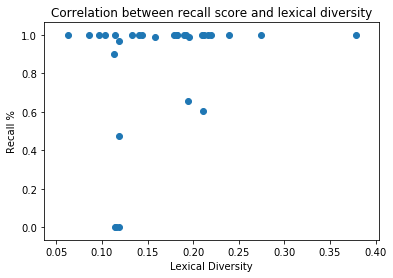

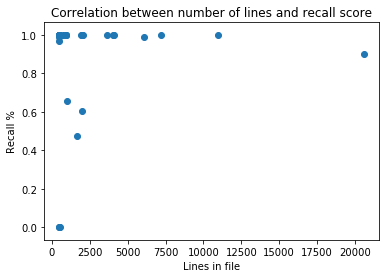

In [31]:
print(np.corrcoef(lens, lex_divs)[0][1]) # Pearson's coeff very close to zero > no correlation
print(np.corrcoef(hitrates, lex_divs)[0][1]) # medium positive correlation = more diversity means better recall
print(np.corrcoef(lens, hitrates)[0][1]) # low positive correlation = longer files have only slightly higher hitrates
plt.scatter(lex_divs, lens)
plt.show()
plt.scatter(lex_divs, hitrates)
plt.ylabel('Recall %')
plt.xlabel('Lexical Diversity')
plt.title('Correlation between recall score and lexical diversity')
plt.show()
plt.scatter(lens, hitrates)
plt.ylabel('Recall %')
plt.xlabel('Lines in file')
plt.title('Correlation between number of lines and recall score')
plt.show()